In [1]:
#!pip install --user torchsummaryX
#pip install pytorch

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")


GPU is available


In [3]:
#!unzip 'data.zip'

In [4]:
#Importing necessary packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from PIL import Image
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import itertools
import torchvision.models as models

torch.__version__

'2.0.1+cu118'

### Loading Images in Dataset

In [5]:
class AnimeDataset(Dataset):
    def __init__(self, root_dir, sketch_transforms=None, color_transforms=None, subset_size=None):
        self.root_dir = root_dir
        self.image_paths = glob.glob(os.path.join(self.root_dir, '*.png'))
        if subset_size is not None and subset_size < len(self.image_paths):
            self.image_paths = random.sample(self.image_paths, subset_size)
        self.sketch_transforms = sketch_transforms
        self.color_transforms = color_transforms
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Read the image file
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert('RGB')

        # Divide the image into sketch and colored images
        width = image.width // 2
        sketch = image.crop((width, 0, image.width, image.height))
        colored = image.crop((0, 0, width, image.height))

        # Apply transformations
        if self.sketch_transforms is not None:
            sketch = self.sketch_transforms(sketch)
        if self.color_transforms is not None:
            colored = self.color_transforms(colored)

        return sketch, colored

In [6]:
sketch_transforms = transforms.Compose([
    transforms.Resize((256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define the transformations for colored images
color_transforms = transforms.Compose([
    transforms.Resize((256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
train_path = '/home/iskhatri/Final_Project/data/train'
train_dataset = AnimeDataset(train_path,
                       sketch_transforms=sketch_transforms,
                       color_transforms=color_transforms)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True
)

In [8]:
len(train_dataloader)

780

In [9]:
val_path = '/home/iskhatri/Final_Project/data/val'
val_dataset = AnimeDataset(val_path,
                       sketch_transforms=sketch_transforms,
                       color_transforms=color_transforms)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=True
)

In [10]:
len(val_dataloader)

251

In [11]:
data_iterator = iter(train_dataloader)
images_train, labels_train = next(data_iterator)


In [12]:
batch_size = 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

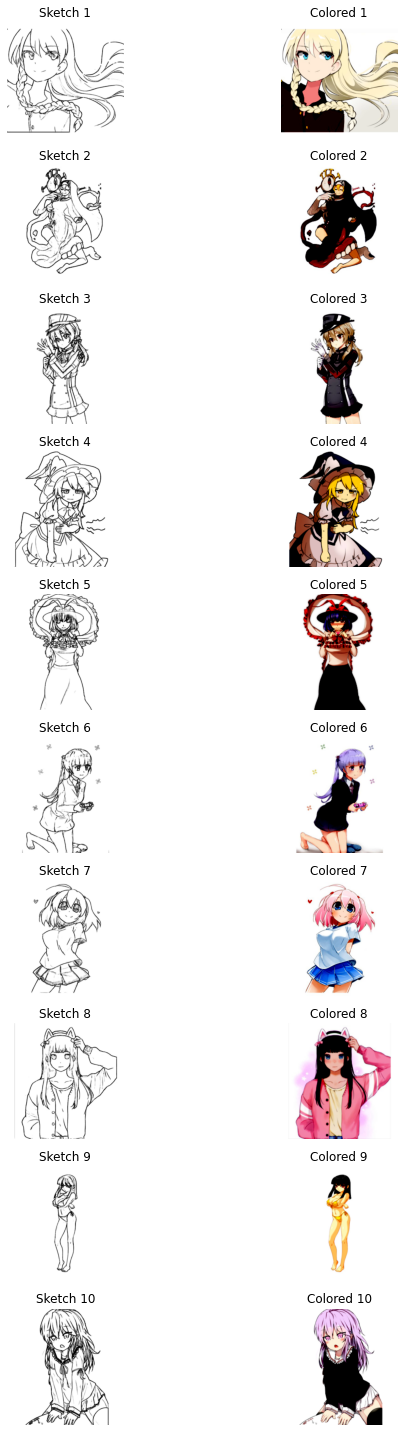

In [13]:
fig, axes = plt.subplots(batch_size, 2, figsize=(10, 2*batch_size))
for i in range(batch_size):
    sketch = images_train[i].permute(1, 2, 0)  # Reorder dimensions for sketch image
    colored = labels_train[i].permute(1, 2, 0)  # Reorder dimensions for colored image

    axes[i, 0].imshow(sketch, cmap='gray')
    axes[i, 0].set_title(f'Sketch {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(colored)
    axes[i, 1].set_title(f'Colored {i+1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.relu = nn.LeakyReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x, is_batch_norm=True):
        x = self.conv(x)
        x = self.relu(x)
        if is_batch_norm:
            x = self.bn(x)
        return x


In [15]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, 
                                         stride=2, padding=1, output_padding =1)
        self.relu = nn.LeakyReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x,  is_drop_out=False):
        x = self.upconv(x)
        x = self.relu(x)
        x = self.bn(x)
        if is_drop_out:
            x = F.dropout2d(x)
        return x
    



### Defining Generator Block

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.enc1 = ConvBlock(3, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.enc5 = ConvBlock(512, 512)
        self.enc6 = ConvBlock(512, 512)
        self.enc7 = ConvBlock(512, 512)
        self.enc8 = ConvBlock(512, 512)
        
        self.dec1 = UpConvBlock(512, 512)
        self.dec2 = UpConvBlock(1024, 512)
        self.dec3 = UpConvBlock(1024, 512)
        self.dec4 = UpConvBlock(1024, 512)
        self.dec5 = UpConvBlock(1024, 256)
        self.dec6 = UpConvBlock(512, 128)
        self.dec7 = UpConvBlock(256, 64)

        self.last = nn.ConvTranspose2d(128, 3, 
                                       kernel_size=3,
                                       stride=2,
                                       padding=1, output_padding=1)
        

    def forward(self, x):
        x1 = self.enc1(x)                # torch.Size([8, 64, 128, 128])
        x2 = self.enc2(x1)               # torch.Size([8, 128, 64, 64])
        x3 = self.enc3(x2)               # torch.Size([8, 256, 32, 32])
        x4 = self.enc4(x3)               # torch.Size([8, 512, 16, 16])
        x5 = self.enc5(x4)               # torch.Size([8, 512, 8, 8])
        x6 = self.enc6(x5)               # torch.Size([8, 512, 4, 4])
        x7 = self.enc7(x6)               # torch.Size([8, 512, 2, 2])
        x8 = self.enc8(x7)               # torch.Size([8, 512, 1, 1])
        
        x8 = self.dec1(x8, is_drop_out=True)   # torch.Size([8, 512, 2, 2])
        x8 = torch.cat([x7, x8], dim=1)   # torch.Size([8, 1024, 2, 2])

        x8 = self.dec2(x8, is_drop_out=True)   # torch.Size([8, 512, 4, 4])
        x8 = torch.cat([x6, x8], dim=1)   # torch.Size([8, 1024, 2, 2])
        
        x8 = self.dec3(x8, is_drop_out=True)   # torch.Size([8, 512, 8, 8])
        x8 = torch.cat([x5, x8], dim=1)   # torch.Size([8, 1024, 8, 8])
        
        x8 = self.dec4(x8)                 # torch.Size([8, 512, 16, 16])
        x8 = torch.cat([x4, x8], dim=1)   # torch.Size([8, 1024, 16, 16])
        
        x8 = self.dec5(x8)                         
        x8 = torch.cat([x3, x8], dim=1)          
        
        x8 = self.dec6(x8)                       
        x8 = torch.cat([x2, x8], dim=1)         
        
        x8 = self.dec7(x8)                        
        x8 = torch.cat([x1, x8], dim=1)         
        
        x8 = torch.tanh(self.last(x8))           
        return x8

### Defining Discriminator Block

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = ConvBlock(6, 64)
        self.layer2 = ConvBlock(64, 128)
        self.layer3 = ConvBlock(128, 256)
        self.conv = nn.Conv2d(256, 512, 3, 1, 1)
        self.batch_norm = nn.BatchNorm2d(512)
        self.last = nn.Conv2d(512, 1, 3, 1)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, image,label):
        x = torch.cat([image, label], axis=1)
        x = self.layer1(x, is_batch_norm=False)
        x = self.layer2(x)
        x = F.dropout2d(self.layer3(x))
        x = F.dropout2d(self.relu(self.conv(x)))
        x = F.dropout2d(self.batch_norm(x))
        x = torch.sigmoid(self.last(x))
        return x

In [18]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [19]:
def print_model_summary(model):
    print(model)
    for name, module in model.named_children():
        print(module)

# Example usage
print_model_summary(generator)


Generator(
  (enc1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc2): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc3): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (enc4): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): LeakyReLU(negative_slope=0.01, inplace=True)
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [20]:
def generate_images(model, test_input, true_target):
    prediction = model(test_input).permute(0, 2, 3, 1).detach().cpu().numpy()
    test_input = test_input.permute(0, 2, 3, 1).cpu().numpy()
    true_target = true_target.permute(0, 2, 3, 1).cpu().numpy()
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], true_target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
LAMBDA = 10
images_train = images_train.to(device) 
labels_train = labels_train.to(device)

### Images before training

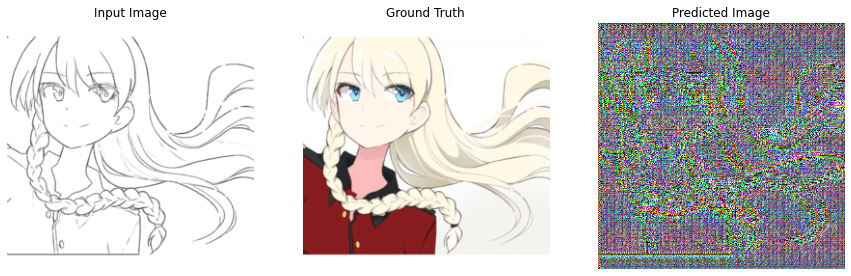

In [21]:
generate_images(generator, images_train, labels_train)

In [22]:
D_loss = [] 
G_loss = []

### Defining Training block

In [23]:
def train_epoch(generator, discriminator, train_dataloader, d_optimizer, g_optimizer, loss_fn, lambda_val, device):
    generator.train()
    discriminator.train()
    D_epoch_loss = 0
    G_epoch_loss = 0

    for step, (imgs, masks) in enumerate(train_dataloader):
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Train discriminator
        d_optimizer.zero_grad()
        real_labels = torch.ones((imgs.size(0), 1, 30, 30), device=device)  # Adjusted size
        fake_labels = torch.zeros((imgs.size(0), 1, 30, 30), device=device)  # Adjusted size

        disc_real_output = discriminator(imgs, masks)
        d_real_loss = loss_fn(disc_real_output, real_labels)
        d_real_loss.backward()

        gen_output = generator(imgs)
        disc_gen_output = discriminator(imgs, gen_output.detach())
        d_fake_loss = loss_fn(disc_gen_output, fake_labels)
        d_fake_loss.backward()

        d_optimizer.step()

        # Train generator
        g_optimizer.zero_grad()
        disc_gen_output = discriminator(imgs, gen_output)
        gen_loss_cgan = loss_fn(disc_gen_output, real_labels)
        gen_loss_l1 = torch.mean(torch.abs(masks - gen_output))
        gen_loss = gen_loss_cgan + lambda_val * gen_loss_l1
        gen_loss.backward()
        g_optimizer.step()

        D_epoch_loss += (d_real_loss.item() + d_fake_loss.item()) / 2
        G_epoch_loss += gen_loss.item()

    D_epoch_loss /= len(train_dataloader)
    G_epoch_loss /= len(train_dataloader)
    return D_epoch_loss, G_epoch_loss

### Defining Validation block

In [24]:
def val_epoch(generator, discriminator, val_dataloader, loss_fn, device):
    generator.eval()
    discriminator.eval()
    val_D_loss = 0
    val_G_loss = 0

    with torch.no_grad():
        for val_step, (val_imgs, val_masks) in enumerate(val_dataloader):
            val_imgs = val_imgs.to(device)
            val_masks = val_masks.to(device)

            real_labels = torch.ones((val_imgs.size(0), 1, 30, 30), device=device)  # Adjusted size

            val_disc_real_output = discriminator(val_imgs, val_masks)
            val_d_real_loss = loss_fn(val_disc_real_output, real_labels)

            val_gen_output = generator(val_imgs)
            val_disc_gen_output = discriminator(val_imgs, val_gen_output)
            val_gen_loss_cgan = loss_fn(val_disc_gen_output, real_labels)
            val_gen_loss_l1 = torch.mean(torch.abs(val_masks - val_gen_output))
            val_gen_loss = val_gen_loss_cgan + val_gen_loss_l1

            val_D_loss += val_d_real_loss.item()
            val_G_loss += val_gen_loss.item()

        val_D_loss /= len(val_dataloader)
        val_G_loss /= len(val_dataloader)
    return val_D_loss, val_G_loss

In [32]:
def train(generator, discriminator, train_dataloader, val_dataloader, num_epochs, lambda_val, device):
    d_optimizer = torch.optim.Adam(discriminator.parameters(), 
                                           lr=2e-4, betas=(0.5, 0.999))
    g_optimizer = torch.optim.Adam(generator.parameters(), 
                                       lr=6e-5, betas=(0.5, 0.999))
    loss_fn = nn.BCELoss()

    D_loss = []
    G_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        print(f"Starting Epoch {epoch + 1}")
        D_epoch_loss, G_epoch_loss = train_epoch(generator, discriminator, train_dataloader, d_optimizer, g_optimizer, loss_fn, lambda_val, device)
        val_D_loss, val_G_loss = val_epoch(generator, discriminator, val_dataloader, loss_fn, device)

        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        val_loss.append((val_D_loss, val_G_loss))

        print(f"Epoch {epoch + 1}: D_loss={D_epoch_loss:.4f}, G_loss={G_epoch_loss:.4f}, Val_D_loss={val_D_loss:.4f}, Val_G_loss={val_G_loss:.4f}")
        
        torch.save(generator.state_dict(), '/home/iskhatri/Final_Project/data/generator.pth')
        torch.save(discriminator.state_dict(), '/home/iskhatri/Final_Project/data/discriminator.pth')
        
    return D_loss, G_loss, val_loss

### Training the Model

In [37]:
num_epochs = 15
lambda_val = 100


D_loss, G_loss, val_loss = train(generator, discriminator, train_dataloader, val_dataloader, num_epochs, lambda_val, device)



Starting Epoch 1
Epoch 1: D_loss=0.1343, G_loss=14.5235, Val_D_loss=1.3538, Val_G_loss=1.5569
Starting Epoch 2
Epoch 2: D_loss=0.1069, G_loss=14.9154, Val_D_loss=1.8026, Val_G_loss=1.9642
Starting Epoch 3
Epoch 3: D_loss=0.0931, G_loss=14.9599, Val_D_loss=1.9848, Val_G_loss=2.2191
Starting Epoch 4
Epoch 4: D_loss=0.1180, G_loss=14.6901, Val_D_loss=1.7503, Val_G_loss=1.9725
Starting Epoch 5
Epoch 5: D_loss=0.0876, G_loss=15.0967, Val_D_loss=2.3123, Val_G_loss=2.5787
Starting Epoch 6
Epoch 6: D_loss=0.0966, G_loss=14.9912, Val_D_loss=2.8018, Val_G_loss=3.0564
Starting Epoch 7
Epoch 7: D_loss=0.1085, G_loss=15.1068, Val_D_loss=2.2287, Val_G_loss=2.4660
Starting Epoch 8
Epoch 8: D_loss=0.0718, G_loss=15.3653, Val_D_loss=2.1368, Val_G_loss=2.3951
Starting Epoch 9
Epoch 9: D_loss=0.1018, G_loss=15.3132, Val_D_loss=2.2508, Val_G_loss=2.4600
Starting Epoch 10
Epoch 10: D_loss=0.0817, G_loss=15.4759, Val_D_loss=2.1445, Val_G_loss=2.3686
Starting Epoch 11
Epoch 11: D_loss=0.1002, G_loss=15.0066,

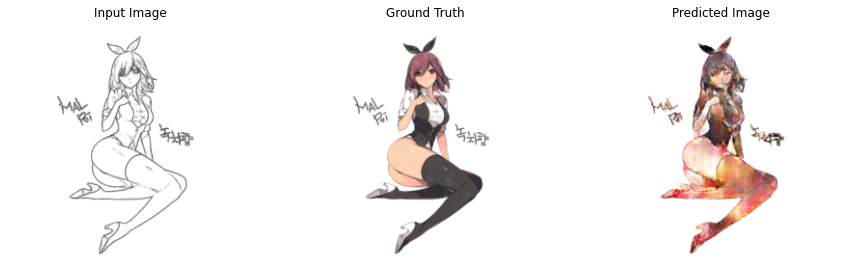

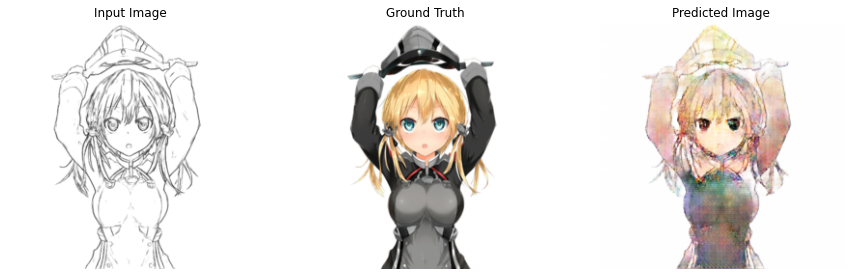

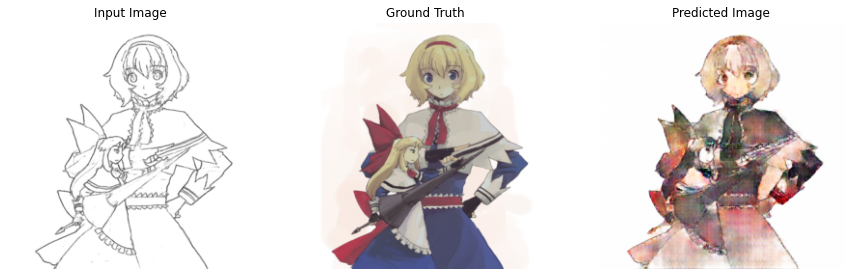

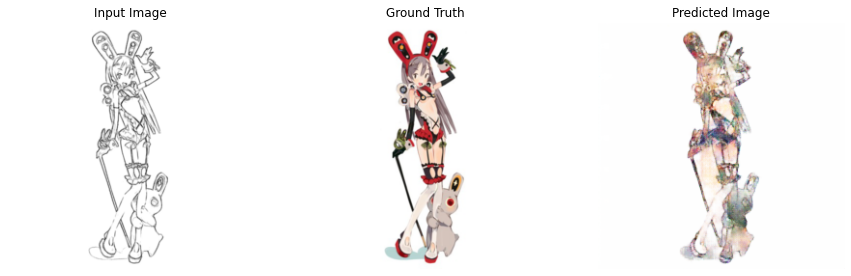

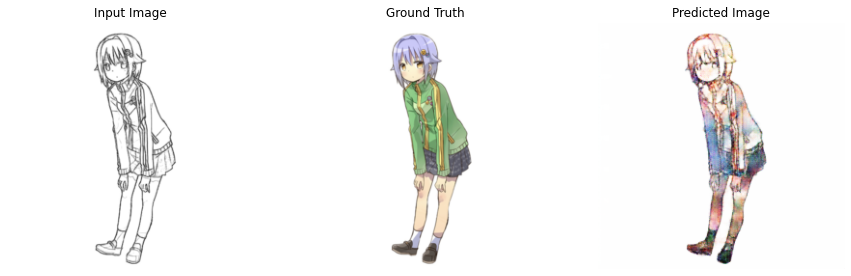

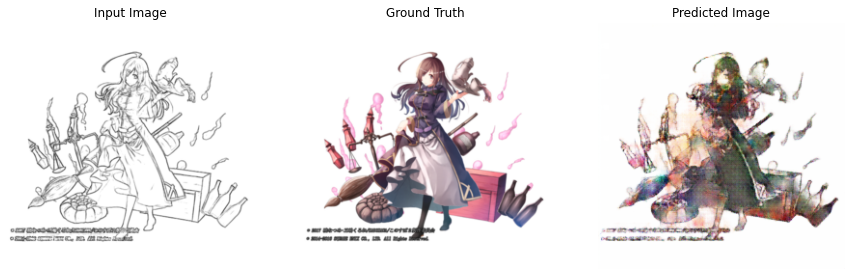

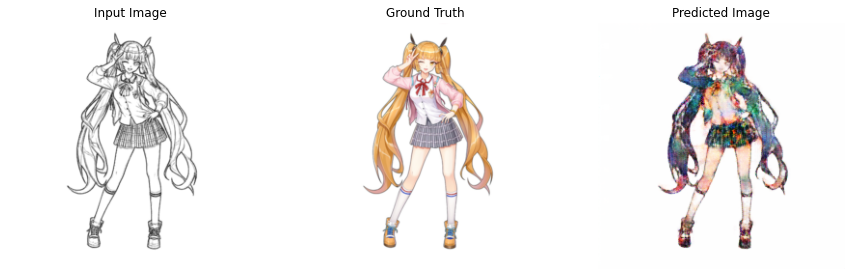

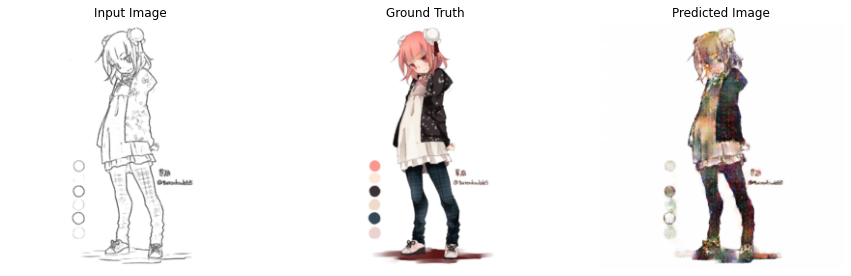

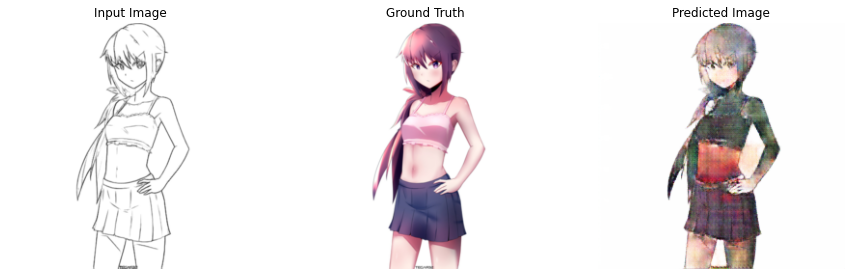

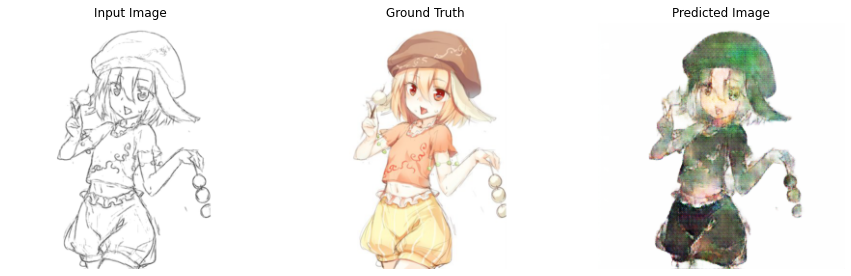

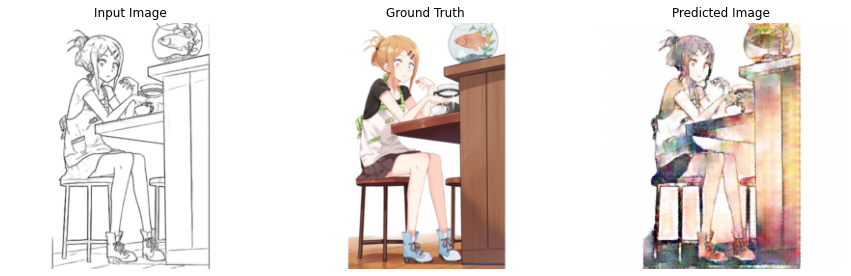

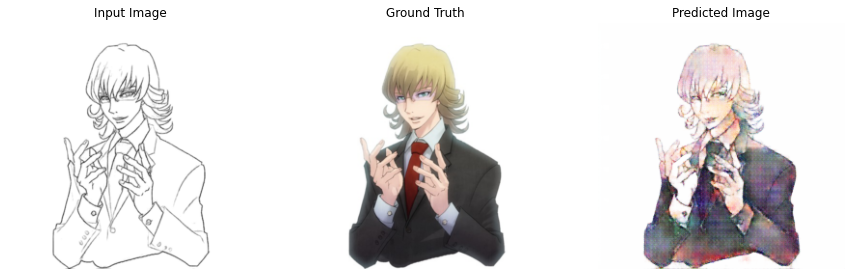

In [42]:
generator = Generator()
discriminator = Discriminator()
generator.to(device)
discriminator.to(device)


generator.load_state_dict(torch.load('/home/iskhatri/Final_Project/data/generator.pth'))
discriminator.load_state_dict(torch.load('/home/iskhatri/Final_Project/data/discriminator.pth'))

generator.eval()
discriminator.eval()

j = 1
with torch.no_grad():
    for val_step, (val_imgs, val_masks) in enumerate(val_dataloader):
        val_imgs = val_imgs.to(device)
        val_masks = val_masks.to(device)
        generate_images(generator, val_imgs, val_masks)
        if j > 15:
            break
        j += 1

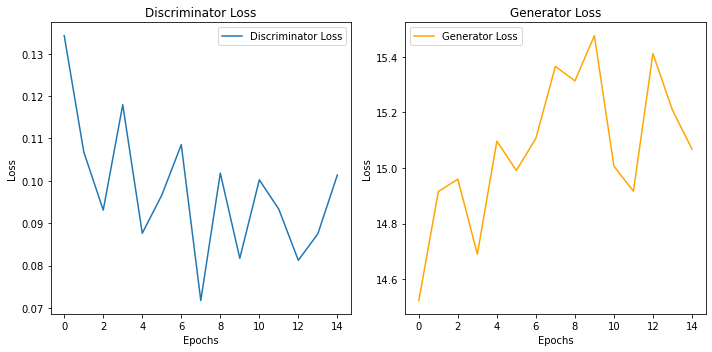

In [39]:
# Plotting Losses
plt.figure(figsize=(10, 5))

# Plot Discriminator Loss
plt.subplot(1, 2, 1)
plt.plot(D_loss, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator Loss")
plt.legend()

# Plot Generator Loss
plt.subplot(1, 2, 2)
plt.plot(G_loss, label="Generator Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator Loss")
plt.legend()

plt.tight_layout()
plt.show()


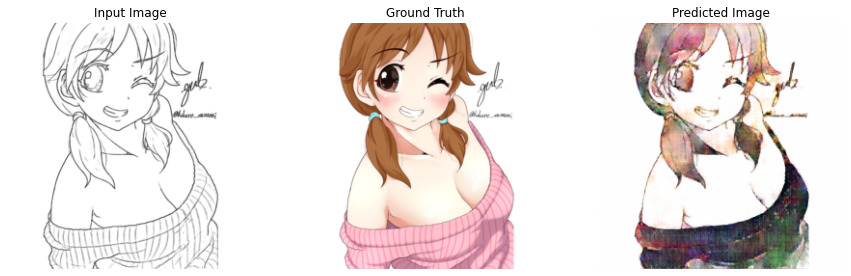

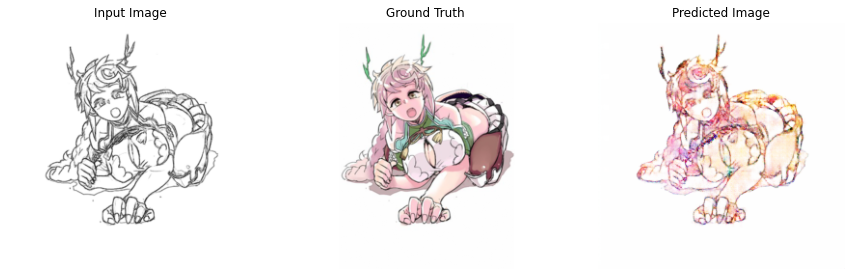

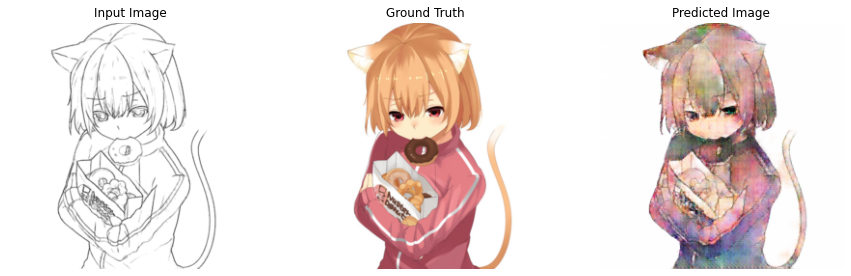

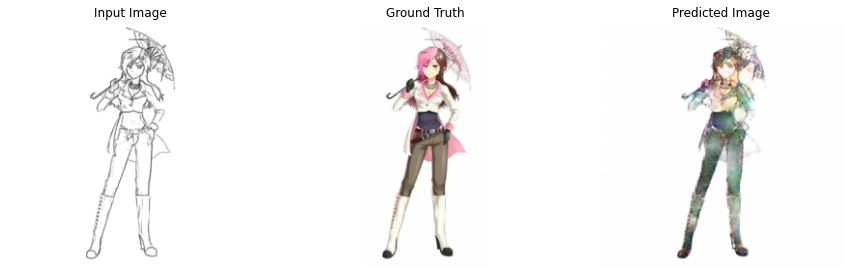

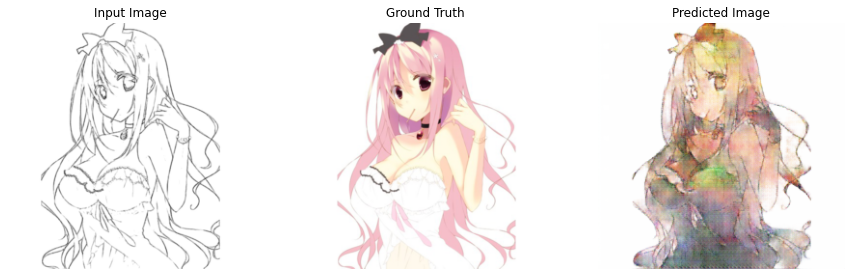

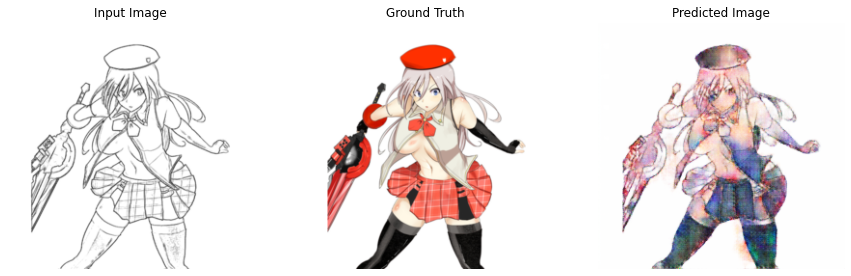

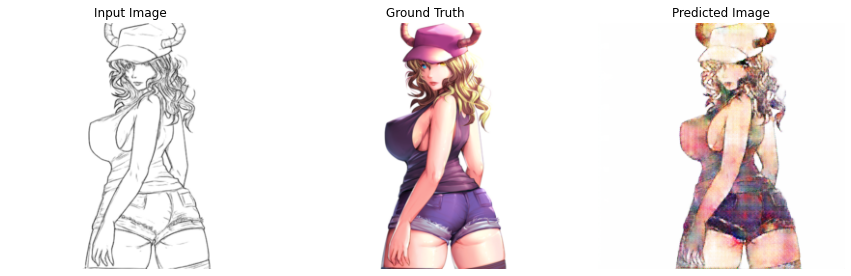

In [41]:
generator = Generator()
discriminator = Discriminator()
generator.to(device)
discriminator.to(device)


generator.load_state_dict(torch.load('/home/iskhatri/Final_Project/data/generator.pth'))
discriminator.load_state_dict(torch.load('/home/iskhatri/Final_Project/data/discriminator.pth'))

generator.eval()
discriminator.eval()

j = 1
with torch.no_grad():
    for val_step, (val_imgs, val_masks) in enumerate(val_dataloader):
        val_imgs = val_imgs.to(device)
        val_masks = val_masks.to(device)
        generate_images(generator, val_imgs, val_masks)
        if j > 15:
            break
        j += 1